# ELAIS-S1 master catalogue
## Preparation of ESO-Spitzer Imaging extragalactic Survey (ESIS) / 2.2-m MPG/ESO telescope at La Silla

The catalogue comes from `dmu0_ESIS-VOICE`.

In the catalogue, we keep:

- The identifier (it's unique in the catalogue);
- The position;
- The stellarity;
- The magnitude for each band in aperture 4 (2"). These are now corrected. 
- The total (auto) magnitude.

We don't know when the maps have been observed. We will use the year of the reference paper.

In [1]:
from herschelhelp_internal import git_version
print("This notebook was run with herschelhelp_internal version: \n{}".format(git_version()))

This notebook was run with herschelhelp_internal version: 
44f1ae0 (Thu Nov 30 18:27:54 2017 +0000)


In [2]:
%matplotlib inline
#%config InlineBackend.figure_format = 'svg'

import matplotlib.pyplot as plt
plt.rc('figure', figsize=(10, 6))

from collections import OrderedDict
import os

from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.table import Column, Table
import numpy as np

from herschelhelp_internal.flagging import  gaia_flag_column
from herschelhelp_internal.masterlist import (nb_astcor_diag_plot, remove_duplicates, 
                                              nb_plot_mag_ap_evol, nb_plot_mag_vs_apcor)
from herschelhelp_internal.utils import aperture_correction, astrometric_correction, mag_to_flux

In [3]:
OUT_DIR =  os.environ.get('TMP_DIR', "./data_tmp")
try:
    os.makedirs(OUT_DIR)
except FileExistsError:
    pass

RA_COL = "voice_ra"
DEC_COL = "voice_dec"

## 0 - Parameters for aperture correction

To compute aperture correction we need to dertermine two parametres: the target aperture and the range of magnitudes for the stars that will be used to compute the correction.

**Target aperture**: To determine the target aperture, we simulate a curve of growth using the provided apertures and draw two figures:
- The evolution of the magnitudes of the objects by plotting on the same plot aperture number vs the mean magnitude.
- The mean gain (loss when negative) of magnitude is each aperture compared to the previous (except for the first of course).

As target aperture, we should use the smallest (i.e. less noisy) aperture for which most of the flux is captures.

**Magnitude range**: To know what limits in aperture to use when doing the aperture correction, we plot for each magnitude bin the correction that is computed and its RMS. We should then use the wide limits (to use more stars) where the correction is stable and with few dispersion.

In [4]:
# We are using the aperture index 4 (1 base) that correspond 2 arcsec
# Apertures 1 to 20 correspond to these diameters (in arc-seconds): 0.5, 1.0,
#  1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0,
#  30.0, 40.0, and 50.0.
AP_INDEX = 4 - 1 #Our aperture nos start at 0

In [5]:
t = Table.read("../../dmu0/dmu0_ESIS-VOICE/data/esis_b2vr_cat_03_HELP-coverage.fits")
bands = {'b99':1, 'b123':2, 'v':3, 'r':4}
apertures      = [1,   2,   3,   4,   5,   6,   7,   8,   9,   10,  11,  12,  13,  14,   15,   16,   17,   18,   19,  20] 
aperture_sizes = [0.5, 1.0, 1.5, 2.0, 2.5, 3.0, 3.5, 4.0, 4.5, 5.0, 6.0, 7.0, 8.0, 9.0, 10.0, 15.0, 20.0, 30.0, 40.0, 50.0] #arcsec aperture sizes

flux = {}
flux_errors ={}
magnitudes = {}
flux_errors ={}
magnitude_errors = {}
stellarities = {}

for col in t.colnames:
    if col.startswith('MAG'):
        t[col][np.isclose(t[col], 99.)] = np.nan

stellarity = t['CLASS_STAR_2']

for band in bands:
    magnitudes[band] = np.array([t[f"MAG_APER_{ap}_{bands[band]}"] for ap in apertures])
    #magnitudes[band] = t['MAG_APER_1_{}'.format(bands[band])]
    #for ap in apertures:
    #    magnitudes[band] = np.stack((magnitudes[band],t['MAG_APER_{}_{}'.format(ap, bands[band])]), axis=0)

#mags_b99 = np.array(t['MAG_APER_r']).T
#mags_r[mags_r == 99] = np.nan

#mags_b123 = np.array(t['MAG_APER_u']).T
#mags_u[mags_u == 99] = np.nan

#mags_v = np.array(t['MAG_APER_g']).T
#mags_g[mags_g == 99] = np.nan

#mags_r = np.array(t['MAG_APER_z']).T
#mags_z[mags_z == 99] = np.nan

#del t

### I.a b99-band

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:850: RuntimeWarning: invalid value encountered in greater
  mags = magnitudes[:, stellarity > stel_threshold].copy()


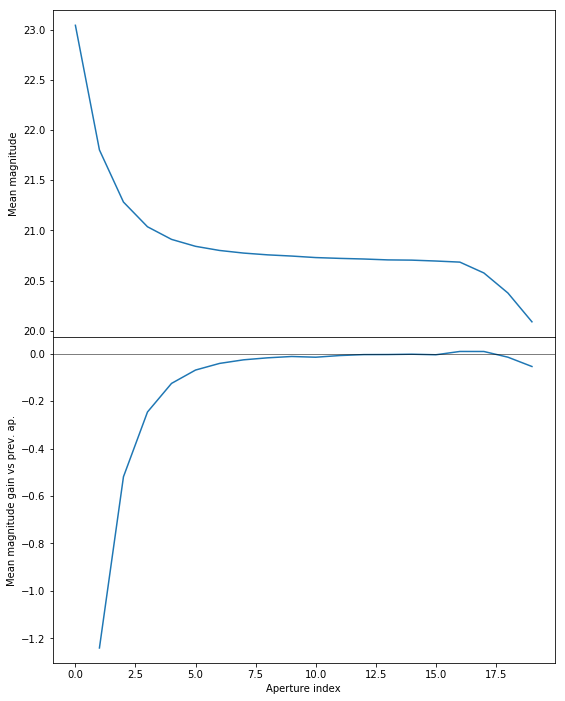

In [6]:
nb_plot_mag_ap_evol(magnitudes['b99'], stellarity)

We will use the 13th (12+1) (aperture number above begin at 0) aperture as target.

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:903: RuntimeWarning: invalid value encountered in greater
  mask = stellarity > .9
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


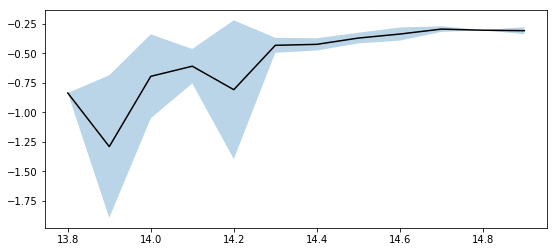

In [7]:
nb_plot_mag_vs_apcor(magnitudes['b99'][AP_INDEX], magnitudes['b99'][12], stellarity)

We use magnitudes between 14.3 and 14.6.

### I.b b123-band

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:850: RuntimeWarning: invalid value encountered in greater
  mags = magnitudes[:, stellarity > stel_threshold].copy()


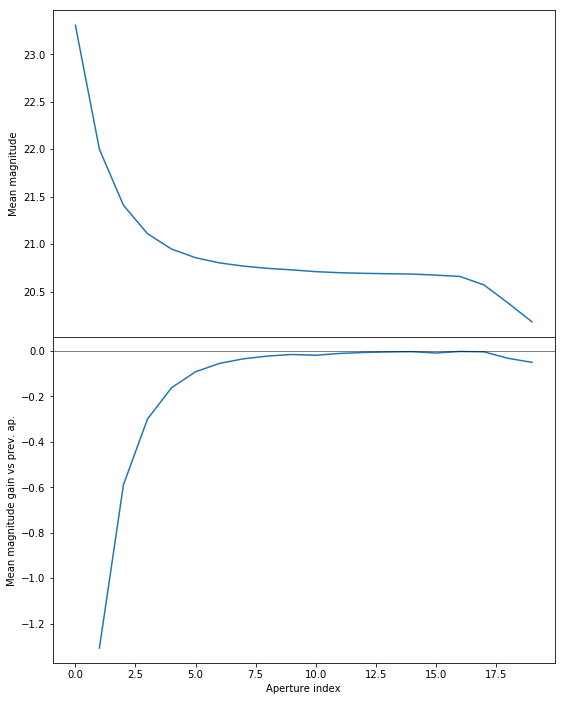

In [8]:
nb_plot_mag_ap_evol(magnitudes['b123'], stellarity)

We will use the 13th (12+1) (aperture number above begin at 0) aperture as target.

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:903: RuntimeWarning: invalid value encountered in greater
  mask = stellarity > .9
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


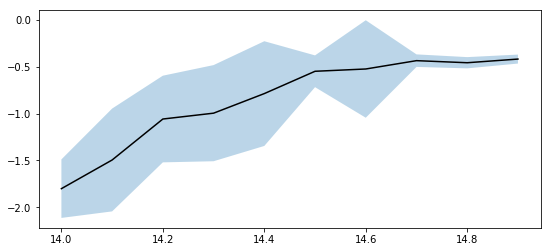

In [9]:
nb_plot_mag_vs_apcor(magnitudes['b123'][AP_INDEX], magnitudes['b123'][12], stellarity)

We use magnitudes between 14.0 and 16.0.

### I.c v-band

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:850: RuntimeWarning: invalid value encountered in greater
  mags = magnitudes[:, stellarity > stel_threshold].copy()


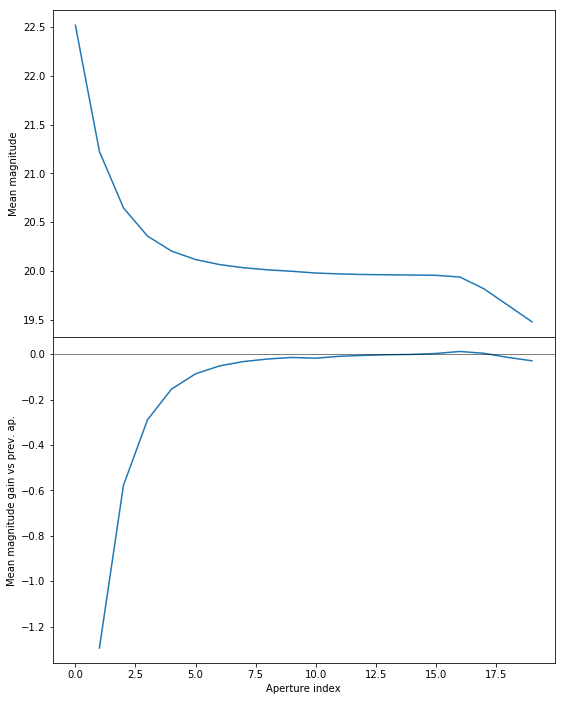

In [10]:
nb_plot_mag_ap_evol(magnitudes['v'], stellarity)

We will use the 13th (12+1) (aperture number above begin at 0) aperture as target.

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:903: RuntimeWarning: invalid value encountered in greater
  mask = stellarity > .9
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


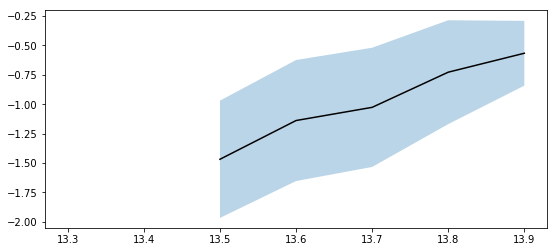

In [11]:
nb_plot_mag_vs_apcor(magnitudes['v'][AP_INDEX], magnitudes['v'][12], stellarity)

We use magnitudes between 14.0 and 16.0.

### I.d r-band

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:850: RuntimeWarning: invalid value encountered in greater
  mags = magnitudes[:, stellarity > stel_threshold].copy()


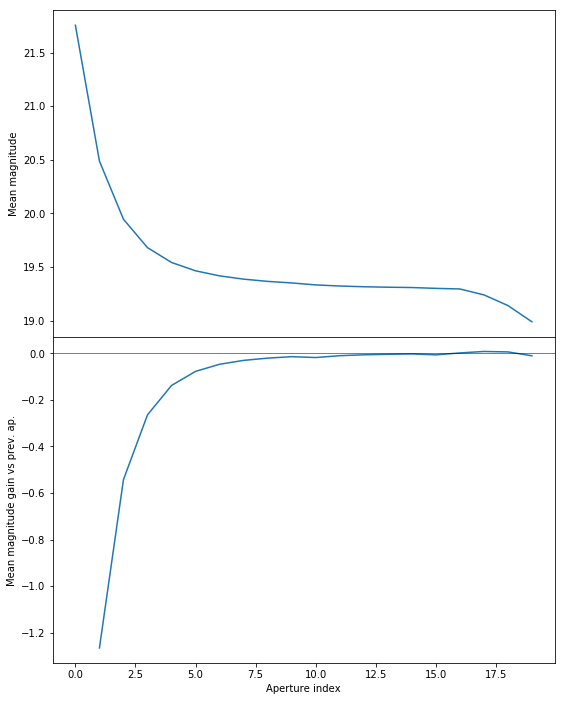

In [12]:
nb_plot_mag_ap_evol(magnitudes['r'], stellarity)

We will use the 13th (12+1) (aperture number above begin at 0) aperture as target.

/opt/herschelhelp_internal/herschelhelp_internal/masterlist.py:903: RuntimeWarning: invalid value encountered in greater
  mask = stellarity > .9
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


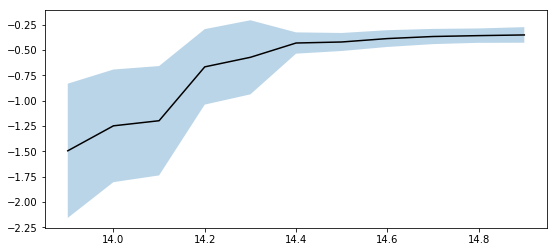

In [13]:
nb_plot_mag_vs_apcor(magnitudes['r'][AP_INDEX], magnitudes['r'][12], stellarity)

We use magnitudes between 14.0 and 16.0.

## I - Column selection

In [14]:
#Aperture 6 is 3 arcsec, Aperture 4 is 2 arcsec. We are now using 2 arcsec!
#There appear to be four bands in the catalogue B99/B123/V89/R162 (1/2/3/4)
#Multiple class star - for each band
imported_columns = OrderedDict({
    'ID':'voice_id', 
    'ALPHA_J2000':'voice_ra', 
    'DELTA_J2000':'voice_dec', 
    'CLASS_STAR_2':'voice_stellarity',     
    'MAG_APER_4_1':'m_ap_voice_b99', 
    'MAGERR_APER_4_1':'merr_ap_voice_b99', 
    'MAG_AUTO_1':'m_voice_b99', 
    'MAGERR_AUTO_1':'merr_voice_b99',
    'MAG_APER_4_2':'m_ap_voice_b123', 
    'MAGERR_APER_4_2':'merr_ap_voice_b123', 
    'MAG_AUTO_2':'m_voice_b123', 
    'MAGERR_AUTO_2':'merr_voice_b123',
    'MAG_APER_4_3':'m_ap_voice_v', 
    'MAGERR_APER_4_3':'merr_ap_voice_v', 
    'MAG_AUTO_3':'m_voice_v', 
    'MAGERR_AUTO_3':'merr_voice_v',
    'MAG_APER_4_4':'m_ap_voice_r', 
    'MAGERR_APER_4_4':'merr_ap_voice_r', 
    'MAG_AUTO_4':'m_voice_r', 
    'MAGERR_AUTO_4':'merr_voice_r'
    })


catalogue = Table.read("../../dmu0/dmu0_ESIS-VOICE/data/esis_b2vr_cat_03_HELP-coverage.fits")[list(imported_columns)]
for column in imported_columns:
    catalogue[column].name = imported_columns[column]

epoch = 2016

# Clean table metadata
catalogue.meta = None

# Index of the target aperture when doing aperture correction
# (see 'sparcs_aperture_correction' notebook).
AP_TARG_INDEX = {
    'b99': 12,
    'b123': 12,
    'v': 12,
    'r': 12
}

# Magnitude range for aperture correction.
APCOR_MAG_LIMITS = {
    'b99': (14.0, 16.0),
    'b123': (14.0, 16.0),
    'v': (14.0, 16.0),
    'r': (14.0, 16.0)
}




for band in ['b99', 'b123', 'v', 'r']:
    
    # Aperture magnitudes
    mag_aper = magnitudes[band][AP_INDEX]
    mag_aper_target = magnitudes[band][ AP_TARG_INDEX[band]]
    magerr_aper = catalogue["merr_ap_voice_{}".format(band)]
    
    # Set bad values (99.0) to NaN
    mask = (mag_aper > 90) | (mag_aper_target > 90) | (magerr_aper > 90)
    mag_aper[mask] = np.nan
    mag_aper_target[mask] = np.nan
    magerr_aper[mask] = np.nan
    
    # Aperture correction
    mag_diff, num, std = aperture_correction(
        mag_aper, mag_aper_target, catalogue['voice_stellarity'],
        mag_min=APCOR_MAG_LIMITS[band][0], mag_max=APCOR_MAG_LIMITS[band][1]
        )
    print("Aperture correction for VOICE band {}:".format(band))
    print("Correction: {}".format(mag_diff))
    print("Number of source used: {}".format(num))
    print("RMS: {}".format(std))
    print("")
    mag_aper += mag_diff
    
    catalogue["m_ap_voice_{}".format(band)] =  mag_aper.data
        
    # Computing the aperture flux columns
    flux_aper, fluxerr_aper = mag_to_flux(mag_aper.data, magerr_aper.data)
    
    catalogue.add_column(Column(
        data = flux_aper * 1.e6,
        name = "f_ap_voice_{}".format(band)
    ))
    catalogue.add_column(Column(
        data = fluxerr_aper * 1.e6,
        name = "ferr_ap_voice_{}".format(band)
    ))
    
    # Auto magnitudes
    
    # Set bad values (99.0) to NaN
    mask = (catalogue["m_voice_{}".format(band)] > 90) | (catalogue["merr_voice_{}".format(band)] > 90)
    catalogue["m_voice_{}".format(band)][mask] = np.nan
    catalogue["merr_voice_{}".format(band)][mask] = np.nan    
    
    
    # Computing the flux columns
    flux, fluxerr = mag_to_flux(catalogue["m_voice_{}".format(band)], 
                                catalogue["merr_voice_{}".format(band)])
    
    catalogue.add_column(Column(
        data = flux * 1.e6,
        name = "f_voice_{}".format(band)
    ))
    catalogue.add_column(Column(
        data = fluxerr * 1.e6,
        name = "ferr_voice_{}".format(band)
    ))
    
    # Band-flag column
    catalogue.add_column(Column(np.zeros(len(catalogue), dtype=bool), 
                             name="flag_voice_{}".format(band)
    ))
        
# TODO: Set to True the flag columns for fluxes that should not be used for SED fitting.



/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:65: RuntimeWarning: invalid value encountered in greater
/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:129: RuntimeWarning: invalid value encountered in greater
  mask &= (stellarity > 0.9)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:131: RuntimeWarning: invalid value encountered in greater_equal
  mask &= (mag >= mag_min)
/opt/herschelhelp_internal/herschelhelp_internal/utils.py:133: RuntimeWarning: invalid value encountered in less_equal
  mask &= (mag <= mag_max)


Aperture correction for VOICE band b99:
Correction: -0.27787113189697266
Number of source used: 83
RMS: 0.04831492984158891



/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/ipykernel/__main__.py:99: RuntimeWarning: invalid value encountered in greater


Aperture correction for VOICE band b123:
Correction: -0.4382314682006836
Number of source used: 711
RMS: 0.11412357895179506

Aperture correction for VOICE band v:
Correction: -0.3730955123901367
Number of source used: 791
RMS: 0.09074258714442375

Aperture correction for VOICE band r:
Correction: -0.36531543731689453
Number of source used: 1325
RMS: 0.12346733267578548



In [15]:
catalogue[:10].show_in_notebook()

idx,voice_id,voice_ra,voice_dec,voice_stellarity,m_ap_voice_b99,merr_ap_voice_b99,m_voice_b99,merr_voice_b99,m_ap_voice_b123,merr_ap_voice_b123,m_voice_b123,merr_voice_b123,m_ap_voice_v,merr_ap_voice_v,m_voice_v,merr_voice_v,m_ap_voice_r,merr_ap_voice_r,m_voice_r,merr_voice_r,f_ap_voice_b99,ferr_ap_voice_b99,f_voice_b99,ferr_voice_b99,flag_voice_b99,f_ap_voice_b123,ferr_ap_voice_b123,f_voice_b123,ferr_voice_b123,flag_voice_b123,f_ap_voice_v,ferr_ap_voice_v,f_voice_v,ferr_voice_v,flag_voice_v,f_ap_voice_r,ferr_ap_voice_r,f_voice_r,ferr_voice_r,flag_voice_r
,,,,,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,mag,mag,mag,,,,,,,,,,,,,,,,,,,,
0,1,9.17825712092,-43.955836523,0.986996,13.6457,8.4457e-05,12.7221,5.16706e-05,13.8121,0.000101843,12.8877,5.22983e-05,13.2024,8.20345e-05,12.2352,4.02783e-05,13.6187,6.49709e-05,12.2731,4.22112e-05,12638.9,0.983156,29592.0,1.40829,False,10843.7,1.01714,25405.1,1.22372,False,19012.3,1.4365,46337.8,1.71902,False,12957.4,0.775379,44747.6,1.7397,False
1,2,9.47919711452,-43.9648762673,0.982173,13.9328,8.45055e-05,12.0554,3.64481e-05,13.7092,6.7729e-05,11.7522,2.88469e-05,13.4154,7.7651e-05,11.1475,3.09307e-05,nan,nan,nan,nan,9701.99,0.755129,54682.7,1.83569,False,11920.8,0.743629,72297.2,1.92086,False,15625.1,1.1175,126179.0,3.5946,False,nan,nan,nan,nan,False
2,3,9.38616907676,-43.9722384073,0.999861,14.101,9.70481e-05,14.0156,7.99634e-05,14.0963,7.23813e-05,14.0903,5.68381e-05,13.6136,8.53511e-05,13.6356,7.10772e-05,13.8217,5.41758e-05,13.4066,3.9822e-05,8310.08,0.742793,8990.02,0.662107,False,8345.9,0.556385,8392.67,0.439354,False,13018.8,1.02343,12757.7,0.835178,False,10748.3,0.536315,15752.8,0.577771,False
3,4,9.85183392833,-43.9831608454,0.997188,13.7183,0.000164294,13.2806,0.000119572,13.9299,7.3718e-05,13.5524,4.90276e-05,13.2434,0.000110415,12.8226,9.92741e-05,13.7306,7.29783e-05,12.5802,5.177e-05,11822.2,1.78894,17691.8,1.9484,False,9727.96,0.660497,13773.4,0.621953,False,18307.4,1.86178,26975.1,2.46646,False,11688.5,0.785649,33722.3,1.60795,False
4,5,8.82068013986,-43.9885337429,0.970392,13.7144,0.00043213,11.3499,0.000112695,13.6692,8.69714e-05,11.1735,2.61241e-05,13.1814,0.000114785,10.8482,3.71954e-05,13.5824,0.000102743,11.0449,3.27186e-05,11864.1,4.72201,104721.0,10.8696,False,12368.4,0.990755,123203.0,2.96439,False,19383.7,2.04927,166233.0,5.69484,False,13397.8,1.26783,138687.0,4.17933,False
5,6,8.79679406122,-43.9850531388,0.0286267,18.2141,0.00144791,15.058,0.000852961,18.2807,0.000906894,14.8657,0.000381861,17.6731,0.00098831,14.2728,0.000451806,16.5674,0.000413796,13.2539,0.000339681,188.088,0.250829,3441.8,2.70389,False,176.898,0.14776,4108.71,1.44506,False,309.569,0.28179,7093.89,2.95197,False,857.085,0.326653,18131.4,5.67256,False
6,7,8.80327818802,-43.9855703407,nan,19.8863,0.00408593,19.7822,0.00610169,nan,nan,nan,nan,nan,nan,nan,nan,17.5704,0.000683203,17.7011,0.000869065,40.3157,0.151719,44.3738,0.249375,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,340.269,0.214116,301.698,0.241491,False
7,8,9.84925878674,-43.9855297377,0.960899,13.6422,0.000158234,12.4718,8.48421e-05,13.9076,7.86197e-05,12.639,3.92947e-05,13.1566,0.000112788,12.0793,6.75566e-05,13.7315,7.33729e-05,11.8414,3.80297e-05,12680.4,1.84803,37263.7,2.91188,False,9930.67,0.719094,31946.1,1.15618,False,19832.3,2.0602,53491.7,3.32836,False,11678.5,0.78922,66593.0,2.33253,False
8,9,9.91952030686,-43.9863998576,nan,21.0626,0.0111676,16.9629,0.00351602,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,nan,13.6444,0.140343,595.445,1.92827,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False,nan,nan,nan,nan,False


## II - Removal of duplicated sources

We remove duplicated objects from the input catalogues.

In [16]:
SORT_COLS = ['merr_ap_voice_b99', 'merr_ap_voice_b123', 'merr_ap_voice_v', 'merr_ap_voice_r']
FLAG_NAME = 'voice_flag_cleaned'

nb_orig_sources = len(catalogue)

catalogue = remove_duplicates(catalogue, RA_COL, DEC_COL, sort_col=SORT_COLS,flag_name=FLAG_NAME)

nb_sources = len(catalogue)

print("The initial catalogue had {} sources.".format(nb_orig_sources))
print("The cleaned catalogue has {} sources ({} removed).".format(nb_sources, nb_orig_sources - nb_sources))
print("The cleaned catalogue has {} sources flagged as having been cleaned".format(np.sum(catalogue[FLAG_NAME])))

/opt/anaconda3/envs/herschelhelp_internal/lib/python3.6/site-packages/astropy/table/column.py:1096: MaskedArrayFutureWarning: setting an item on a masked array which has a shared mask will not copy the mask and also change the original mask array in the future.
Check the NumPy 1.11 release notes for more information.
  ma.MaskedArray.__setitem__(self, index, value)


The initial catalogue had 524564 sources.
The cleaned catalogue has 521143 sources (3421 removed).
The cleaned catalogue has 2873 sources flagged as having been cleaned


## III - Astrometry correction

We match the astrometry to the Gaia one. We limit the Gaia catalogue to sources with a g band flux between the 30th and the 70th percentile. Some quick tests show that this give the lower dispersion in the results.

In [17]:
gaia = Table.read("../../dmu0/dmu0_GAIA/data/GAIA_ELAIS-S1.fits")
gaia_coords = SkyCoord(gaia['ra'], gaia['dec'])

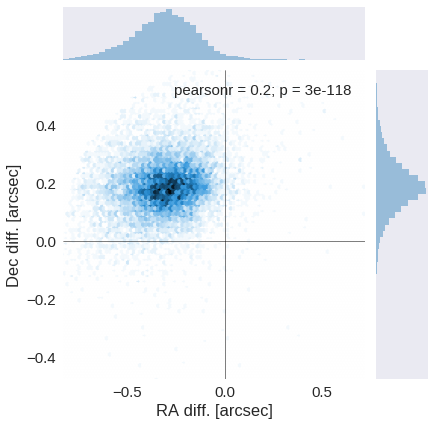

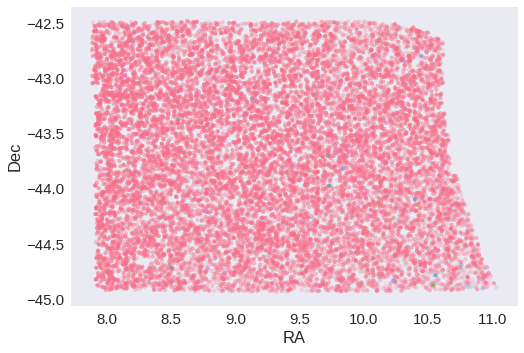

In [18]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

In [19]:
delta_ra, delta_dec =  astrometric_correction(
    SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]),
    gaia_coords
)

print("RA correction: {}".format(delta_ra))
print("Dec correction: {}".format(delta_dec))

RA correction: 0.3032766990468616 arcsec
Dec correction: -0.18594075015698763 arcsec


In [20]:
catalogue[RA_COL] +=  delta_ra.to(u.deg)
catalogue[DEC_COL] += delta_dec.to(u.deg)

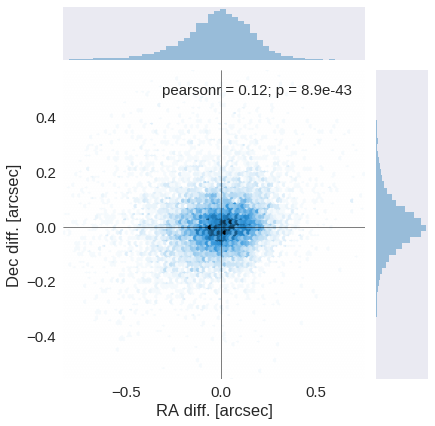

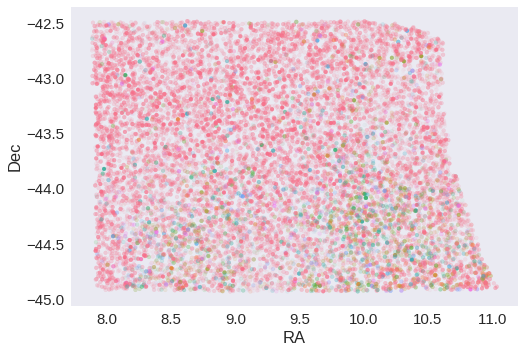

In [21]:
nb_astcor_diag_plot(catalogue[RA_COL], catalogue[DEC_COL], 
                    gaia_coords.ra, gaia_coords.dec)

## IV - Flagging Gaia objects

In [22]:
catalogue.add_column(
    gaia_flag_column(SkyCoord(catalogue[RA_COL], catalogue[DEC_COL]), epoch, gaia)
)

In [23]:
GAIA_FLAG_NAME = "voice_flag_gaia"

catalogue['flag_gaia'].name = GAIA_FLAG_NAME
print("{} sources flagged.".format(np.sum(catalogue[GAIA_FLAG_NAME] > 0)))

13627 sources flagged.


## V - Flagging objects near bright stars

# VI - Saving to disk

In [24]:
catalogue.write("{}/ESIS-VOICE.fits".format(OUT_DIR), overwrite=True)